In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [4]:
def replace_outliers_with_median(df):
    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Sostituisci gli outlier con la mediana
            median = df_clean[col].median()
            df_clean[col] = df_clean[col].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

    return df_clean


In [5]:
def remove_outliers(df):

    df_clean = df.copy()  # Copia il DataFrame originale per non modificarlo direttamente

    for col in df.columns:
        if col != 'quality':
            q1 = df[col].quantile(0.25)  # Calcola il primo quartile
            q3 = df[col].quantile(0.75)  # Calcola il terzo quartile
            iqr = q3 - q1  # Calcola l'interquartile range (IQR)

            # Calcola i limiti per gli outlier
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Rimuovi gli outlier
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

In [6]:
def new_quality_value(df):
    
    new_df = df.copy()
    # Mappa i valori della colonna 'quality' 
    quality_mapping = {3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2}
    new_df['quality'] = new_df['quality'].replace(quality_mapping)
    
    return new_df


In [7]:
def classificator (dataset, classifier, testsize):
    accuracy_dict={}
    x_data=dataset.drop(columns=[classifier])
    y_data=dataset.loc[:,classifier]
    x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=testsize,random_state=10)

    accuracy_dict['Size']= round(dataset.shape[0],0)
    # RandomForestClassifier 
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=20)
    rf_model.fit(x_train, y_train)

    y_pred = rf_model.predict(x_test)

    # Valutazione delle prestazioni del modello
    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello RandomForestClassifier: %.3f" %accuracy)
    accuracy_dict['RandomForest']=round(accuracy,3)

    # Classificatore SVM con solo relevant feature
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

    svm_classifier.fit(x_train, y_train)
    y_pred = svm_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore SVM: %.3f" %accuracy)
    accuracy_dict['SVM']=round(accuracy,3)

    # Crea il modello di regressione logistica con solo relevant
    logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=42)

    logistic_regression.fit(x_train, y_train)
    y_pred = logistic_regression.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del modello di regressione logistica: %.3f" %accuracy)
    accuracy_dict['Regression']=accuracy

    # DecisionTreeClassifier con tutte le feature
    tree_classifier = DecisionTreeClassifier(random_state=42)

    tree_classifier.fit(x_train, y_train)
    y_pred = tree_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore ad albero decisionale: %.3f" %accuracy)
    accuracy_dict['Tree']=round(accuracy,3)


    # Classificatore naive bayes con relevant feature
    naive_bayes_classifier = GaussianNB()
    naive_bayes_classifier.fit(x_train, y_train)

    y_pred = naive_bayes_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    #print("Accuratezza del classificatore Naive Bayes: %.3f" %accuracy)
    accuracy_dict['Bayes']=round(accuracy,3)

    return accuracy_dict


In [13]:
def classification(dataframe, testsize):

    data=dataframe.copy()

    data_clean=replace_outliers_with_median(data)
    data_clean_remove=remove_outliers(data)

    relevant=dataframe.drop(columns=['fixed_acidity','residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH'])
    relevant_clean=replace_outliers_with_median(relevant)
    relevant_clean_remove=remove_outliers(relevant)

    result=pd.DataFrame()

    result['Data']=classificator(data,'quality',testsize)

    result['Relevant']=classificator(relevant,'quality', testsize)

    result['Data_Clean']=classificator(data_clean,'quality', testsize)

    result['Relevant_Clean']=classificator(relevant_clean, 'quality', testsize)

    result['Data_Remove']=classificator(data_clean_remove,'quality', testsize)

    result['Relevant_Remove']=classificator(relevant_clean_remove, 'quality', testsize)

    new_data=new_quality_value(data)

    result['New_Data']=classificator(new_data,'quality', testsize)

    relevant_new=new_data.drop(columns=['fixed_acidity','residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH'])
    result['New_Relevant']=classificator(relevant_new,'quality', testsize)

    data_clean_new=replace_outliers_with_median(new_data)
    result['New_Data_Clean']=classificator(data_clean_new,'quality', testsize)

    relevant_clean_new=replace_outliers_with_median(relevant_new)
    result['New_Relevant_Clean']=classificator(relevant_clean_new,'quality', testsize)

    data_clean_new_remove=remove_outliers(new_data)
    result['New_Data_Remove']=classificator(data_clean_new_remove,'quality', testsize)

    relevant_new_remove=remove_outliers(relevant_new)
    result['New_Relevant_Remove']=classificator(relevant_new_remove,'quality', testsize)

    result.iloc[0] = result.iloc[0].astype(int)
    return result


In [9]:
def plot_result(res):
    num=res.iloc[0]
    result=res.drop(index='Size')
    num_cols = len(result.columns)
    num_rows = (num_cols + 1) // 2 

    # Creazione del grafico a barre
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

    # Itera sul DataFrame e crea i subplot
    for i, (col_name, col_data) in enumerate(result.items()):
        row = i // 2
        col = i % 2
        keys = result.index
        values = col_data
        colors = plt.cm.RdBu(np.array(values) / max(values))
        
        for j, v in enumerate(values):
            axs[row, col].text(j, v + 0.01, f"{v:.2f}", ha='center', va='bottom')
        
        axs[row, col].bar(keys, values, color=colors)
        axs[row, col].set_ylabel('Valori')
        axs[row, col].set_title('Dataset name='+col_name+'   Dataset size='+str(num.iloc[i]))
        axs[row, col].set_xticks(keys)
        axs[row, col].set_xticklabels(keys, rotation=45, ha='right')
        axs[row, col].set_ylim(0, max(values) * 1.2)

    # Rimuovi i subplot non utilizzati
    for i in range(num_cols, num_rows*2):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()


In [10]:
wine_dataframe = pd.read_csv('restore_winedata.csv')
result=pd.DataFrame()
data=wine_dataframe.copy()
data.shape

(1599, 12)

In [ ]:
r_10=classification(data,0.10)
plot_result(r_10)

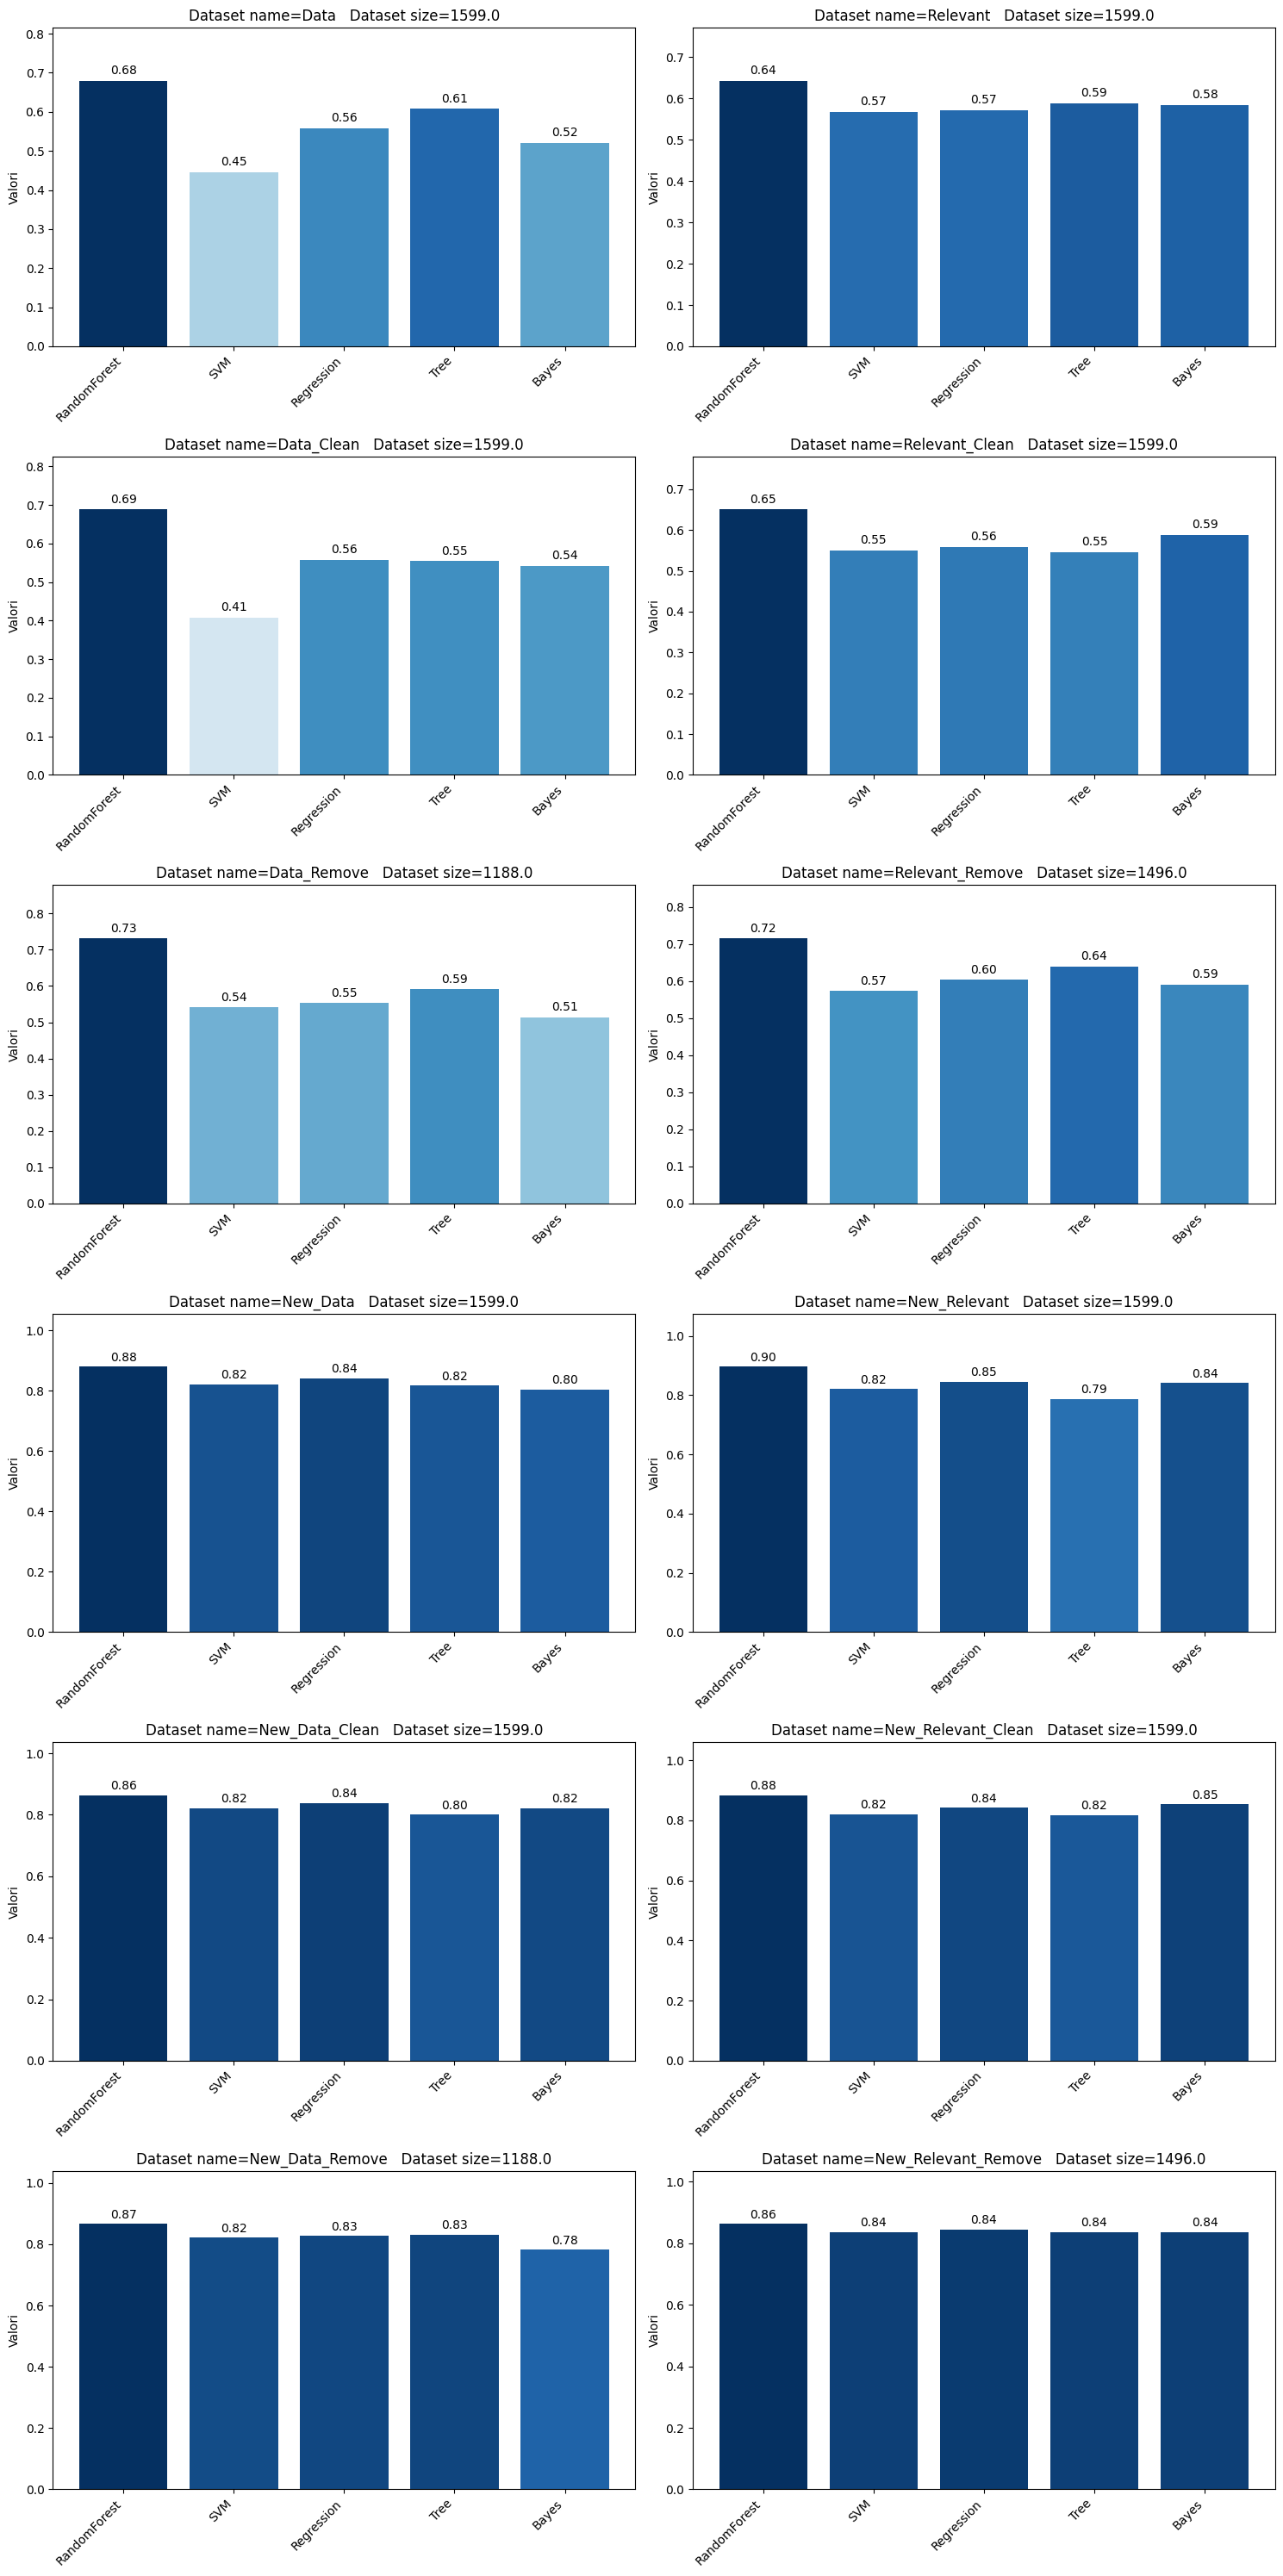

In [16]:
r_15=classification(data,0.15)
plot_result(r_15)